In this notebook, `cylFF.py` is first used to reproduce Figure 10.3 from "Foundations for Guided-Wave Optics" by Chin-Lin Chen (2006). Then `cylFF.py` is used to create a plot of the optical fiber emission angle for the fundamental mode for a range of core radii $a$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The cylFF file is imported directly, since it has not yet been incorporated into the ofiber distribution version:

In [2]:
import importlib.util
import os

spec = importlib.util.spec_from_file_location("cylFF.py",os.path.abspath("../ofiber/cylFF.py"))

cylFF = importlib.util.module_from_spec(spec)

spec.loader.exec_module(cylFF)


Array for the polar angle $\Theta$:

In [3]:
thetares = 3001
Theta = np.linspace(0,np.pi/2,thetares)

## Chen Figure 10.3

Parameters for Chen Fig. 10.3. Only the combination of $k$ and $a$, $ka = 20.3$, is specified or needed.

In [4]:
k = 1.
a = 20.3
V=2.4
b=0.53303

Angle in degrees at which $ka \sin \Theta = V \sqrt{1-b}$, and at which we could use Chen Eq. (10.14) instead of Eq. (10.13) to calculate `FFazim`.

In [5]:
(180/np.pi)*np.arcsin(V*np.sqrt(1-b)/(k*a))

4.63399869993096

Calculate the azimuthally integrated intensity in the far-field (Fraunhofer) limit of the fundamental mode as a function of polar angle, given the distance and fiber parameters:

In [6]:
IFF = cylFF.IrradFFxazint(R=2*np.pi,Theta=Theta,l=0,lmbd=2*np.pi,a=20.3,V=2.4,b=0.53303)

Plot the intensity to reproduce Chen figure 10.3:

Specifically, create a polar plot of an azimuthally integrated function from $\Theta = -90$ to $+90$ degrees

Theta: array going from -90 to +90 degrees, in radians

F: intensity vs polar angle Theta

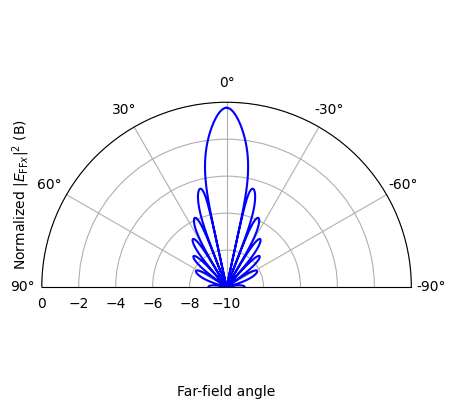

In [7]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N") 
ax.set_thetalim(np.pi / 2, -np.pi / 2)
Flog10 = np.log10(np.divide(IFF,2.*IFF[0]))
# Need to divide by 2 because otherwise, by using negative and positive angles, we are double counting the azimuthal integration
plt.xlabel('Far-field angle')
plt.ylabel(r'Normalized $|E_{\mathrm{FF}x}|^2$ (B)')

ax.plot(Theta, Flog10, 'b', -Theta, Flog10, 'b')

ax.set_ylim(-10,0)
ax.grid(True)


## Sweep of emission angle vs core radius $a$

In [8]:
import ofiber

### Calculate dispersion vs $a$
Calculate $V$ and $b$, for the fundamental mode $\text{LP}_{01}$, for a range of fiber core radii $a$, given $n_{\mathrm{co}}$ and $n_{\mathrm{cl}}$.

Create an array of core radii $a$ in microns ($\mu \text{m}$).

In [9]:
aRadArr = np.linspace(2,15,num=131)

Calculate the relative refractive index $\Delta$, numerical aperture NA, and generalized frequency $V$ from the core $n_{\mathrm{co}}$ and cladding $n_{\mathrm{cl}}$ refractive indices.

In [10]:
n_co = 1.589
n_cl = 1.48
lmbd0 = 0.55 # use the approx. center wavelength of the visible light spectrum, 550 nm, as the free space wavelength 
Delta = ofiber.relative_refractive_index(n_co,n_cl)
NA = ofiber.numerical_aperture_from_Delta(n_co,Delta)
Varr = ofiber.V_parameter(aRadArr,NA,lmbd0)

In [11]:
import scipy

Initialize an empty array for the generalized guide index $b$:

In [12]:
barr = np.zeros(Varr.shape)

The routine `ofiber.cylinder_step.LP_mode_value` works for the first $V$ value. We use this to find the lower bound for all remaining $b$ values. (Using a lower bound of $b=0$ in the bracketing algorithm may lead to errors.)

In [13]:
barr[0] = ofiber.cylinder_step.LP_mode_value(V=Varr[0],ell=0,em=1)

Calculate $b$ for each $V(a)$. The routine `ofiber.cylinder_step.LP_mode_value` breaks down for very large $V$ values, so an alternate method, taking advantage of the monotonic increase of $b(V)$, is used below:

In [14]:
for i in range(1,barr.shape[-1]):
    barr[i] = (scipy.optimize.root_scalar(f=ofiber.cylinder_step._cyl_mode_eqn, args=(Varr[i], 0),bracket=(barr[i-1],1))).root

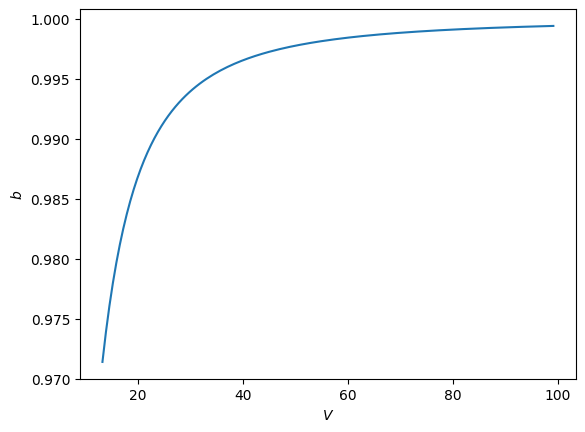

In [15]:
plt.xlabel(r'$V$')
plt.ylabel(r'$b$')
plt.plot(Varr,barr)

### Calculate the irradiance for each $a$ and $\Theta$

Initialize an empty array for the intensity $|E_{\mathrm{FF}x}|^{2}$ with shape $(N_{\Theta},N_{a})$:

In [16]:
I_a_Theta = np.zeros((Theta.size,aRadArr.size))

Calculate the intensity vs $\Theta$ in a loop over $a$:

In [17]:
for i in range(barr.shape[-1]):
    I_a_Theta[:,i] = cylFF.IrradFFxazint(R=1,Theta=Theta,l=0,lmbd=lmbd0,a=aRadArr[i],V=Varr[i],b=barr[i]) 

### Extract the polar angle of the minimum of the central irradiance lobe for each $a$ value. 
Find the first minimum $\Theta_{01}$ of $I \propto |E_{\mathrm{FF}x}|^{2}$ when starting the search from $\Theta = 0$ and increasing. (For the fundamental mode, the first minimum is always at a nonzero $\Theta$.)

In [18]:
firstMinArr = np.zeros(aRadArr.size)

In [19]:
for i in range(aRadArr.size):
    peaks, _ = scipy.signal.find_peaks(-I_a_Theta[:,i])
    firstMinArr[i] = Theta[peaks[0]]

### Plot of emission angle vs fiber radius

Define the fit function for the angle $\Theta_{01}$ vs $a$ curve.

In this regime, an excellent fit function is $\Theta_{01}(a) = \frac{b}{a} + c$. The inverse of this fit is $\frac{b}{\Theta - c} = a$.

In [20]:
def fxinv(x, a, b):
    return np.add(np.divide(a,x),b)

The x-axis data is the $a$ array:

In [21]:
xdata = aRadArr

Convert $\Theta_{01}$ from radians to degrees, to ease visualization:

In [22]:
firstMinDegArr = np.multiply(firstMinArr,180/np.pi)

Fit the $x^{-1}$ function to the data:

In [23]:
popt, pcov = scipy.optimize.curve_fit(fxinv, xdata, firstMinDegArr)

Plot the emission angle calculations and the fit function:

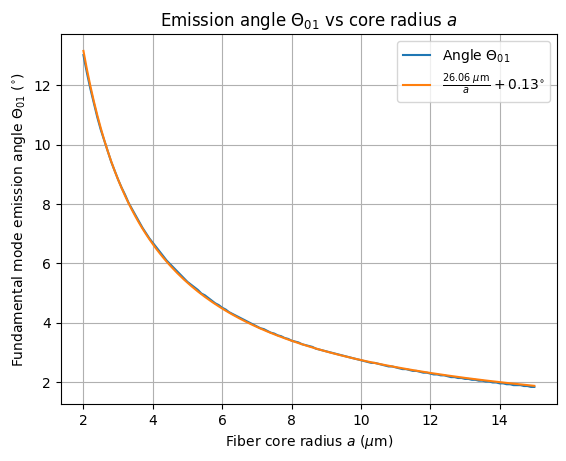

In [24]:
plt.xlabel(r'Fiber core radius $a$ ($\mu$m)')
plt.ylabel(r'Fundamental mode emission angle $\Theta_{01}$ ($^{\circ}$)')
plt.title(r'Emission angle $\Theta_{01}$ vs core radius $a$')
plt.plot(aRadArr,firstMinDegArr,label=r'Angle $\Theta_{01}$')
plt.plot(aRadArr,fxinv(xdata,popt[0],popt[1]),label=r'$\frac{%5.2f \ \mu \text{m}}{a} + %5.2f^{\circ}$' % tuple(popt))
plt.grid()
plt.legend()